In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skies

%config InlineBackend.figure_format = "retina"

In [2]:
MM2M = 1e-3
KM2M = 1e3
Y2S = 365.25 * 24 * 3600
MIN_GEOMETRIC_MOMENT = 1e-10
depth = 15e3
years = 100
reference_slip_deficit_rate = 30 * MM2M / Y2S  # mm/yr
n_pts = 1000
x = np.linspace(0, depth, n_pts)
segment_area = x[1] - x[0]

coseismic_slip_magnitude = 5.0
coseismic_slip = coseismic_slip_magnitude * np.cos(x / depth * np.pi / 2.0) ** 3.0
slip_deficit_rate = reference_slip_deficit_rate * np.cos(x / depth * np.pi / 2.0)
accumulated_geometric_moment = slip_deficit_rate * years * Y2S * segment_area
coseismic_geometric_moment = coseismic_slip * segment_area
residual_geometric_moment_all = accumulated_geometric_moment - coseismic_geometric_moment
residual_geometric_moment = residual_geometric_moment_all.copy()
residual_geometric_moment[residual_geometric_moment <= 0] = MIN_GEOMETRIC_MOMENT


In [23]:
def plot_geometric_moments_and_afterslip_velocities():
    # Geometric moments
    plt.figure(figsize=(10, 4.5))
    plt.subplot(1, 2, 1)

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array([accumulated_geometric_moment / segment_area, np.zeros(n_pts)]).flatten()
    plt.fill(
            fill_x,
            fill_y / 1e3,
            color="cyan",
            label="accumulated",
        )

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array([-coseismic_geometric_moment / segment_area, np.zeros(n_pts)]).flatten()
    plt.fill(
            fill_x,
            fill_y / 1e3,
            color="orange",
            label="coseismic",
        )

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array([residual_geometric_moment_all / segment_area, np.zeros(n_pts)]).flatten()
    plt.fill(
            fill_x,
            fill_y / 1e3,
            color="lightgrey",
            label="residual", alpha=0.5, 
        )
    

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array([-m_afterslip_corrected, np.zeros(n_pts)]).flatten()
    plt.fill(
            fill_x,
            fill_y / 1e3,
            color="black",
            label="afterslip", alpha=0.5, 
        )

    plt.plot(accumulated_geometric_moment / segment_area, x / KM2M, "-k", linewidth=0.5)
    plt.plot(-coseismic_geometric_moment / segment_area, x / KM2M, "-k", linewidth=0.5)
    plt.plot(residual_geometric_moment_all / segment_area, x / KM2M, "-k", linewidth=0.5)
    plt.plot([0, 0], [0, 15], "-k", linewidth=0.5)

    plt.xlim(-5, 5)
    plt.ylim([0, 15])
    plt.yticks([0, 5, 10, 15])
    plt.gca().invert_yaxis()
    plt.xlabel("$m_i \; / \; a_i$ (m)")
    plt.ylabel("$d$ (km)")
    plt.legend(loc="lower left")

    # After-slip velocities
    plt.subplot(1, 2, 2)
    colors = plt.get_cmap("plasma_r")(np.linspace(0.0, 1.0, len(t)))
    for i in range(len(t)):
        plt.plot(v[:, i], x / 1e3, "-k", linewidth=0.5)
        fill_y = np.array([x, np.flip(x)]).flatten()
        fill_x = np.array([v[:, i], np.zeros(n_pts)]).flatten()
        plt.fill(
            fill_x,
            fill_y / 1e3,
            color=colors[i, 0:3],
            label="t = {:.2f} years".format(t[i] * Y2S),
        )
    plt.xlabel("$v$ (m / yr)")
    plt.ylabel("$d$ (km)")
    # plt.xlim([, ])
    plt.yticks([0, 5, 10, 15])
    plt.ylim([0, 15])
    plt.gca().set_xlim(left=0.0)
    plt.gca().invert_yaxis()
    # plt.legend()
    plt.show()


In [21]:
def calc_V(c, gamma, m_coseismic, g, h, f):
    numerator = c ** 2 * gamma * m_coseismic
    denominator = np.sum(g * h / f)
    V = numerator / denominator
    return V

def calc_v0(V, g, h):
    v0 = V * g * h
    return v0

def calc_m_afterslip(gamma, m_coseismic, g, h, f):
    numerator = gamma * g * h * m_coseismic
    denominator = f * np.sum(g * h / f)
    m_afterslip = numerator / denominator
    return m_afterslip

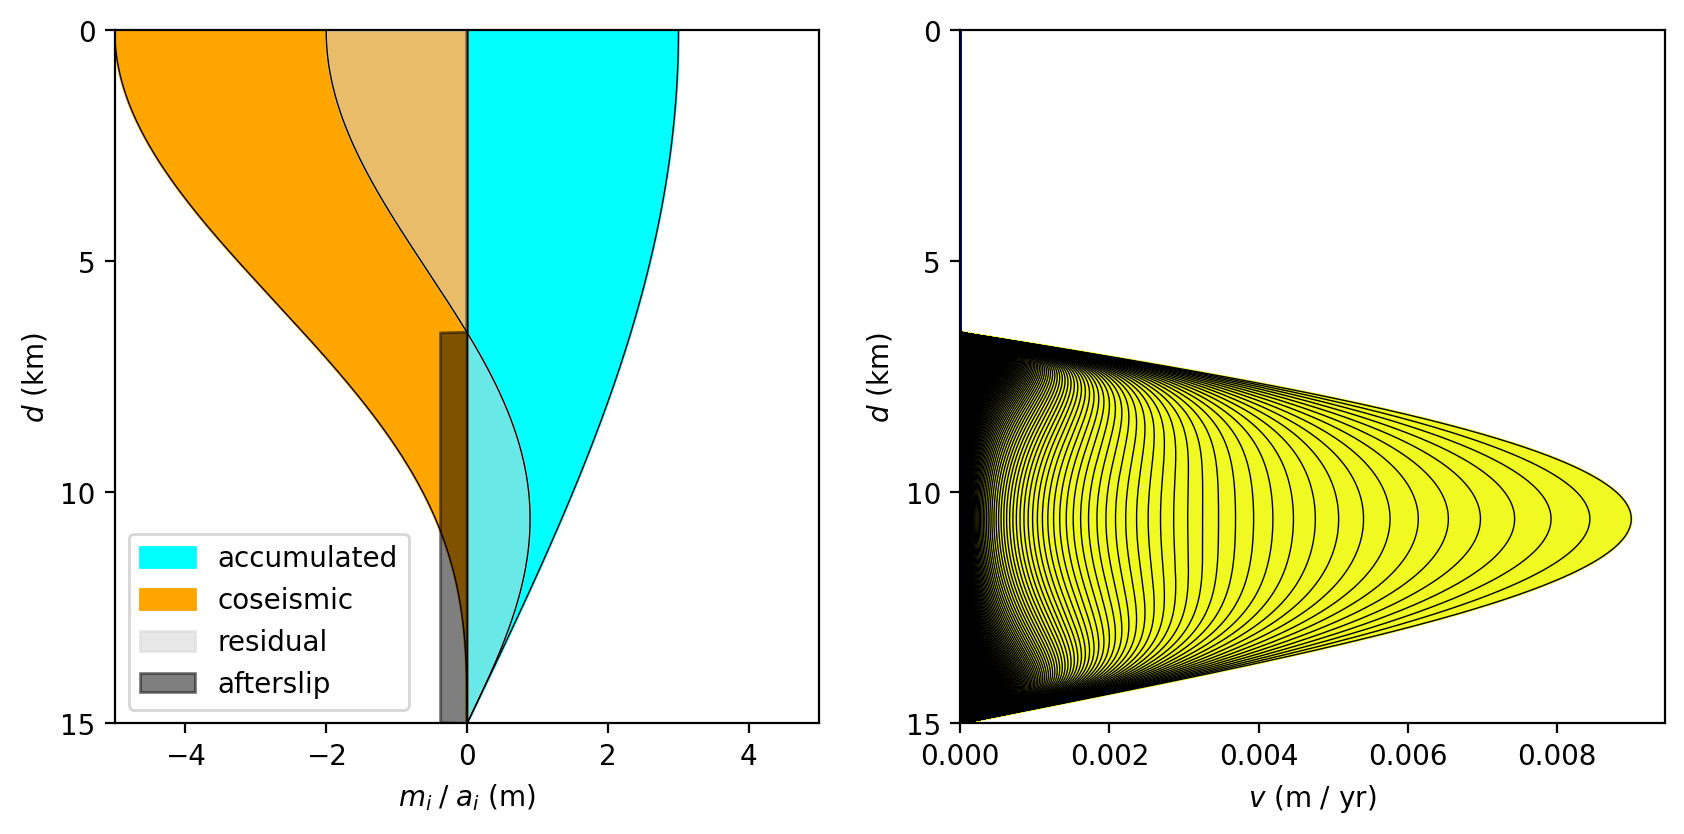

np.sum(m_afterslip)=212.2443841984208
212.24438419842085
121.93258880841331
2122.443841984208


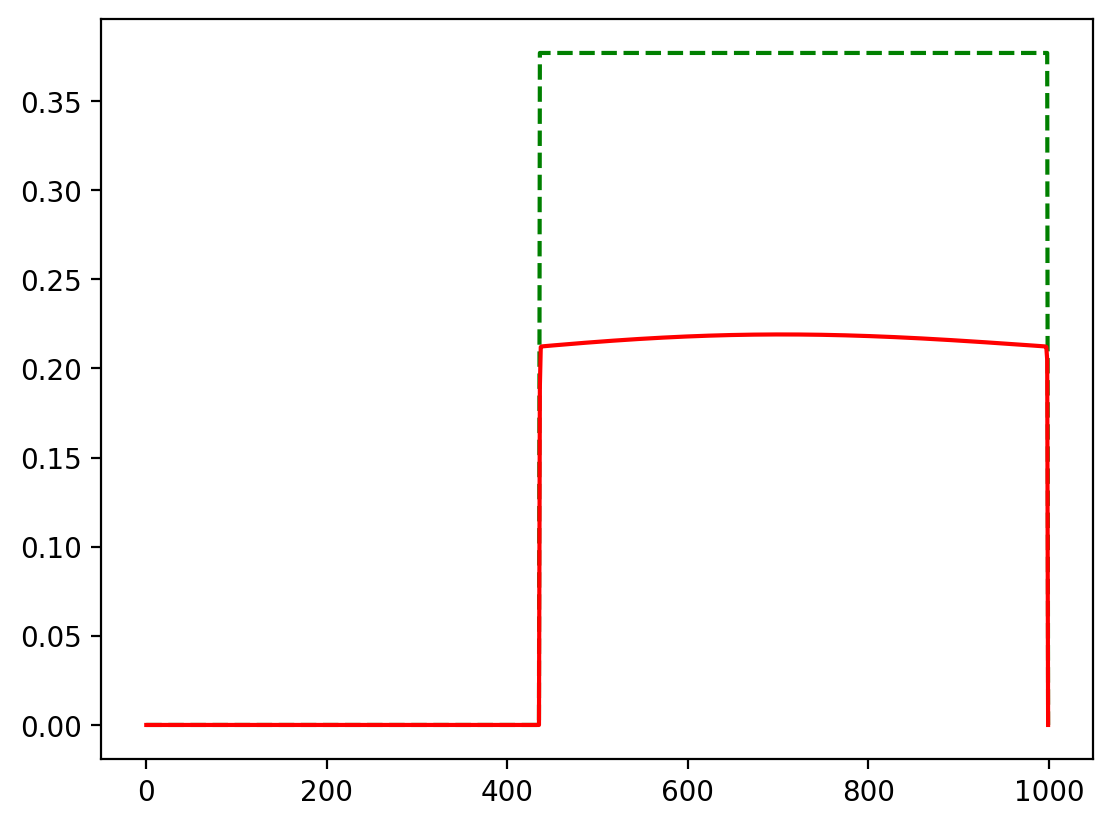

In [34]:
gamma = 0.1
c = 0.00001
m_coseismic = np.sum(coseismic_geometric_moment / segment_area)

f = residual_geometric_moment
g = residual_geometric_moment
h = m_coseismic
V = calc_V(c, gamma, m_coseismic, g, h, f)
v0 = calc_v0(V, g, h)
t = np.linspace(0, 1000, 10000) * Y2S
dt = t[1] - t[0]

v = np.zeros((n_pts, len(t)))
for i in range(len(t)):
    v[:, i] = v0 * np.exp(-(c**2.0) * f * segment_area * t[i])
v = v * Y2S # IS THIS NECCESARY?  IF SO, WHY?

# Analytic geometric moment
m_afterslip = calc_m_afterslip(gamma, m_coseismic, g, h, f)
m_afterslip_corrected = np.zeros(n_pts)

# Analytic fterslip correction for non-negative areas
non_zero_segments = np.where(residual_geometric_moment > MIN_GEOMETRIC_MOMENT)[0]
m_afterslip_corrected[non_zero_segments] = np.sum(m_afterslip) / len(non_zero_segments) 
plot_geometric_moments_and_afterslip_velocities()


m_afterslip_numerical = np.sum(v * dt / Y2S * segment_area, axis=1)

print(f"{np.sum(m_afterslip)=}")
print(np.sum(m_afterslip_corrected))
print(np.sum(m_afterslip_numerical))
print(np.sum(coseismic_slip))


# DEBUG: Plot afterslip distributions
plt.figure()
plt.plot(m_afterslip_corrected, "--g")
plt.plot(m_afterslip_numerical, "-r")
plt.show()

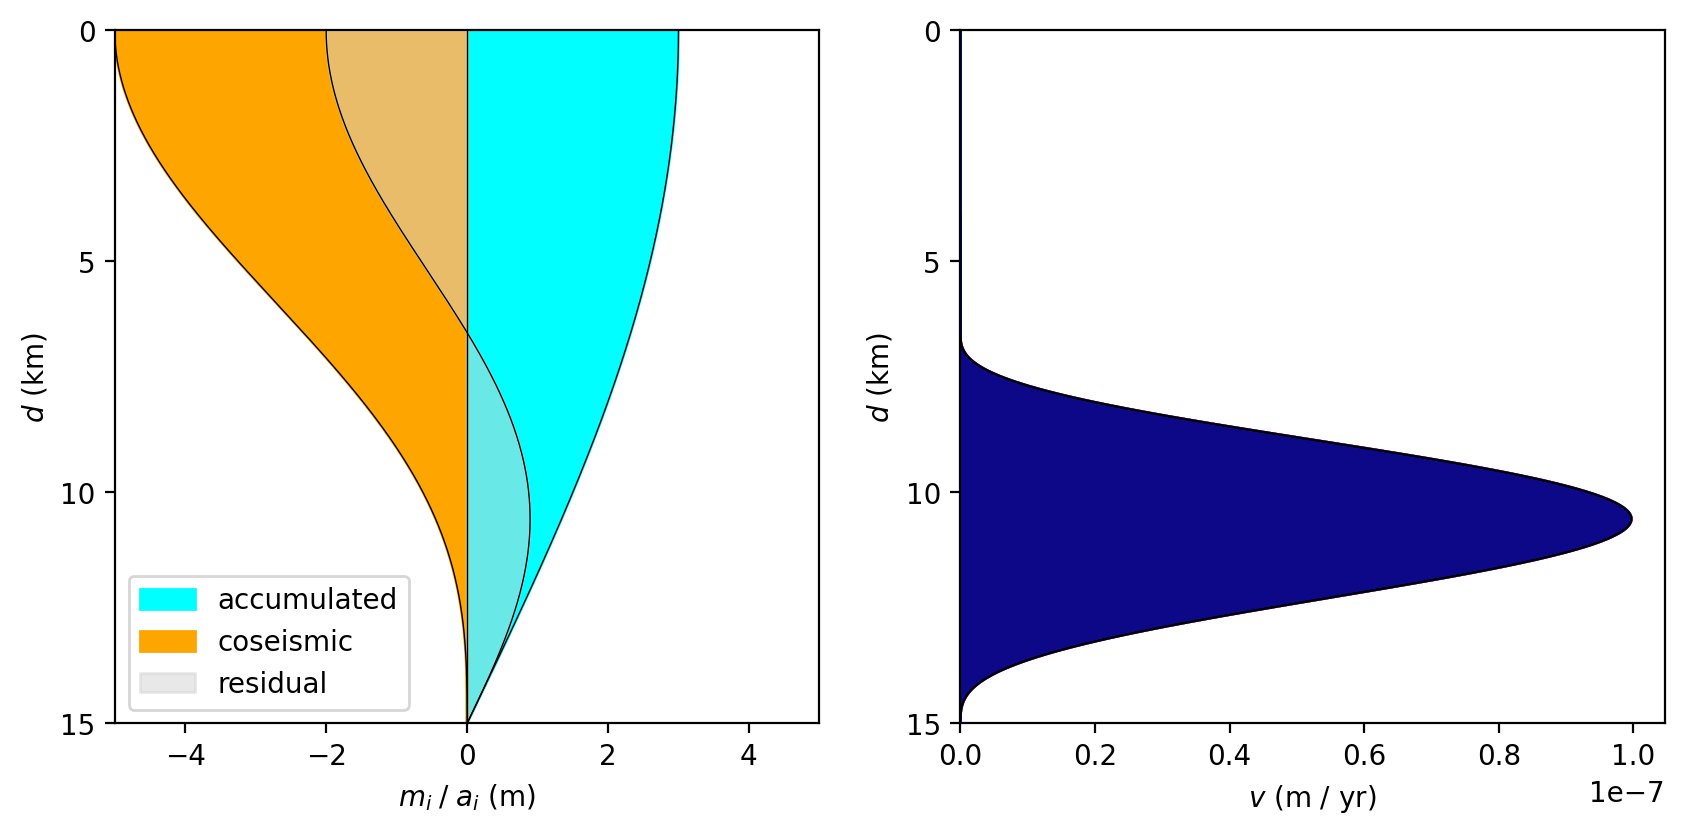

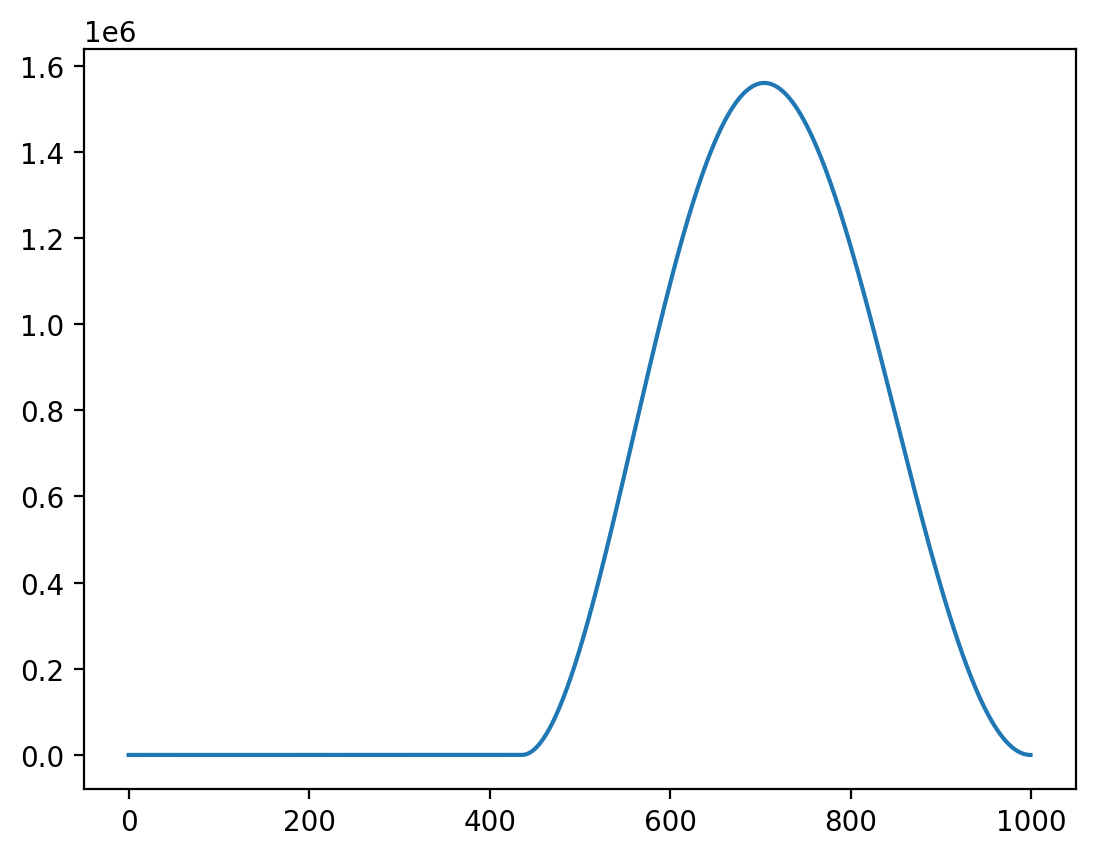

In [6]:
f = residual_geometric_moment
g = residual_geometric_moment ** 3.0
h = m_coseismic
V = calc_V(c, gamma, m_coseismic, g, h, f)
v0 = calc_v0(V, g, h)
t = np.array([0.1, 1.0, 2.0, 5.0, 10.0]) / Y2S

v = np.zeros((n_pts, len(t)))
for i in range(len(t)):
    v[:, i] = v0 * np.exp(-(c**2.0) * f * segment_area * t[i])
plot_geometric_moments_and_afterslip_velocities()


m_afterslip = calc_m_afterslip(gamma, m_coseismic, g, h, f)
plt.figure()
plt.plot(m_afterslip * Y2S / segment_area)
plt.show()

In [7]:
# coseismic_slip_magnitude = 3.0
# coseismic_slip = coseismic_slip_magnitude * np.cos(x / depth * np.pi / 2.0) ** 4.0
# slip_deficit_rate = reference_slip_deficit_rate * np.cos(x / depth * np.pi / 2.0) ** 0.25
# accumulated_geometric_moment = slip_deficit_rate * years * Y2S * segment_area
# coseismic_geometric_moment = coseismic_slip * segment_area
# residual_geometric_moment_all = accumulated_geometric_moment - coseismic_geometric_moment
# residual_geometric_moment = residual_geometric_moment_all.copy()
# residual_geometric_moment[residual_geometric_moment <= 0] = MIN_GEOMETRIC_MOMENT

# f = residual_geometric_moment
# g = residual_geometric_moment ** 3.0
# h = m_coseismic
# V = calc_V(c, gamma, m_coseismic, g, h, f)
# v0 = calc_v0(V, g, h)
# t = np.array([0.1, 1.0, 2.0, 5.0, 10.0]) / Y2S
# v = np.zeros((n_pts, len(t)))
# for i in range(len(t)):
#     v[:, i] = v0 * np.exp(-(c**2.0) * f * segment_area * t[i])
# plot_geometric_moments_and_afterslip_velocities()


In [8]:
# coseismic_slip_magnitude = 3.5
# coseismic_slip = coseismic_slip_magnitude * np.cos(x / depth * np.pi / 2.0) ** 1.0

# for i in range(5):
#     factor = 1 / ((i + 1) ** 3)
#     coseismic_slip += (
#         1 / (i + 1) * np.random.rand(1) * np.cos(x / depth * np.pi / factor) ** 1.0
#     )

# coseismic_slip *= np.cos(x / depth * np.pi / 2.0) ** 1.0
# coseismic_slip[coseismic_slip < 0.0] = 0.0

# slip_deficit_rate = reference_slip_deficit_rate * np.cos(x / depth * np.pi / 2.0) ** (
#     0.25
# )
# accumulated_geometric_moment = slip_deficit_rate * years * Y2S * segment_area
# coseismic_geometric_moment = coseismic_slip * segment_area
# residual_geometric_moment_all = (
#     accumulated_geometric_moment - coseismic_geometric_moment
# )
# residual_geometric_moment = residual_geometric_moment_all.copy()
# residual_geometric_moment[residual_geometric_moment <= 0] = MIN_GEOMETRIC_MOMENT

# f = residual_geometric_moment
# g = residual_geometric_moment ** 3.0
# h = m_coseismic
# V = calc_V(c, gamma, m_coseismic, g, h, f)
# v0 = calc_v0(V, g, h)
# t = np.array([0.1, 1.0, 2.0, 5.0, 10.0]) / Y2S
# v = np.zeros((n_pts, len(t)))
# for i in range(len(t)):
#     v[:, i] = v0 * np.exp(-(c**2.0) * f * segment_area * t[i])
# plot_geometric_moments_and_afterslip_velocities()


In [9]:
np.exp(-1)

0.36787944117144233

In [10]:
1/ segment_area

0.0666

In [11]:
dt

35064000.0

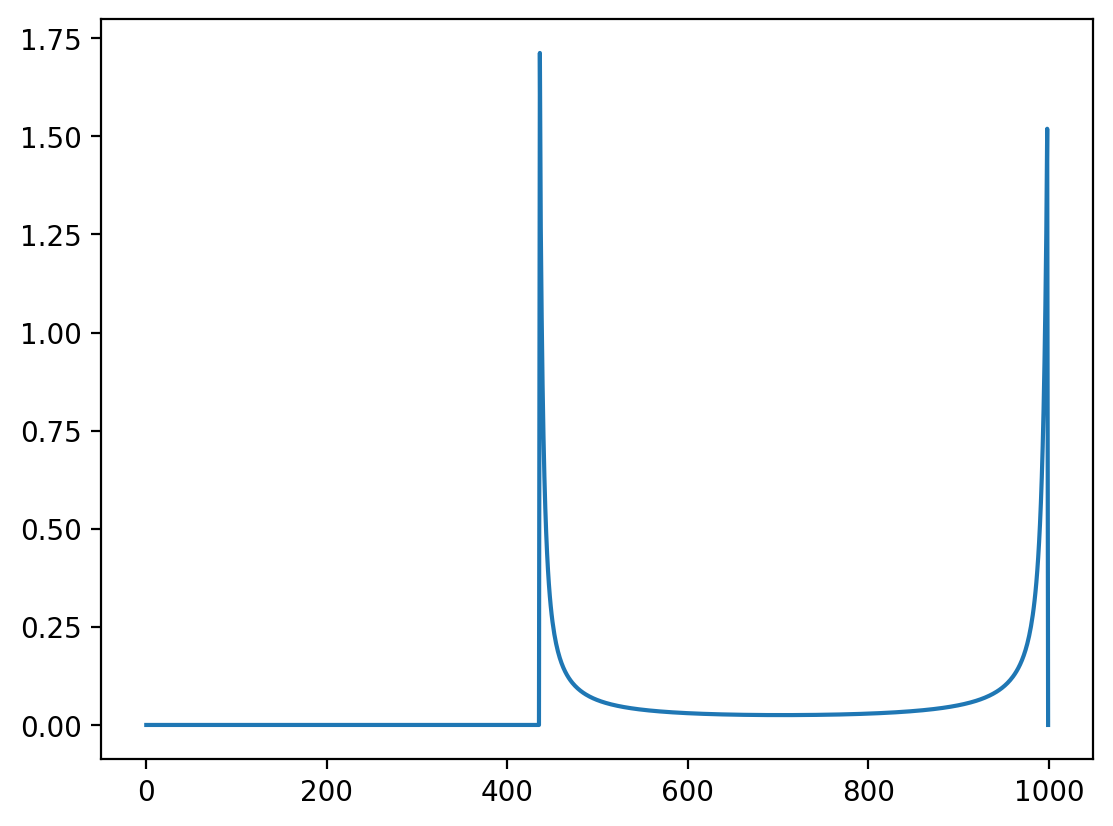

In [12]:
plt.plot(m_afterslip_corrected / (m_afterslip_numerical ))
